In [90]:
import os
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

import torch
from datasets import Dataset, Image
from torch.utils.data import DataLoader

from typing import List, Union, Tuple

from transformers import CLIPProcessor, CLIPModel

import faiss
import pinecone

## **Creating Image Embedding Using OpenAI Clip**

In [50]:
device = "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [40]:
image_path = os.listdir('/Users/shashankvats/projects_openai/FlickerSearchEngine/flicker30k/Images/')
image_path = ['/Users/shashankvats/projects_openai/FlickerSearchEngine/flicker30k/Images/' + path for path in image_path if '.jpg' in path]
image_path.sort()

In [4]:
captions_df = pd.read_csv('captions.csv')

In [91]:
def encode_images(images: Union[List[str], List[PIL.Image.Image]], batch_size: int):
    def transform_fn(el):
        if isinstance(el['image'], PIL.Image.Image):
            imgs = el['image']
        else:
            imgs = [Image().decode_example(_) for _ in el['image']]
        return preprocess(images=imgs, return_tensors='pt')
        
    dataset = Dataset.from_dict({'image': images})
    dataset = dataset.cast_column('image',Image(decode=False)) if isinstance(images[0], str) else dataset       
    dataset.set_format('torch')
    dataset.set_transform(transform_fn)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    image_embeddings = []
    pbar = tqdm(total=len(images) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k:v.to(device) for k,v in batch.items()}
            image_embeddings.extend(model.get_image_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(image_embeddings)

vector_embedding = np.array(encode_images(image_path,32))

994it [09:29,  1.75it/s]                         


In [8]:
def encode_text( text: List[str], batch_size: int):
    device =  "cpu"
    dataset = Dataset.from_dict({'text': text})
    dataset = dataset.map(lambda el: preprocess(text=el['text'], return_tensors="pt",
                                                        max_length=77, padding="max_length", truncation=True),
                            batched=True,
                            remove_columns=['text'])
    dataset.set_format('torch')
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    pbar = tqdm(total=len(text) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            text_embeddings.extend(model.get_text_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(text_embeddings)

## **Saving Image Embeddings as JSON**

In [9]:
with open('flicker30k_image_embeddings.pkl','wb') as f:
    pickle.dump(vector_embedding, f)

In [84]:
import pickle
with open('flicker30k_image_embeddings.pkl', 'rb') as fp:
    vector_embedding = pickle.load(fp)

## **Building Index Using FAISS**

In [85]:
index = faiss.IndexFlatIP(vector_embedding.shape[1])
index.add(vector_embedding)

## **Text to Image Search**

In [71]:
search_text = "basketball game"
with torch.no_grad():
    text_search_embedding = encode_text([search_text], batch_size=32)
text_search_embedding = text_search_embedding/np.linalg.norm(text_search_embedding, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00,  5.65it/s]


In [72]:
distances, indices = index.search(text_search_embedding.reshape(1, -1), 5)
distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

print(indices_distances)

[(12495, 2.984418), (31450, 2.9924636), (7043, 3.0066931), (14687, 3.031371), (4281, 3.1327822)]


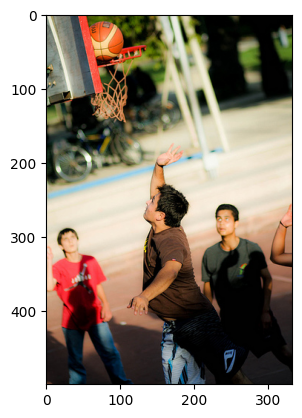

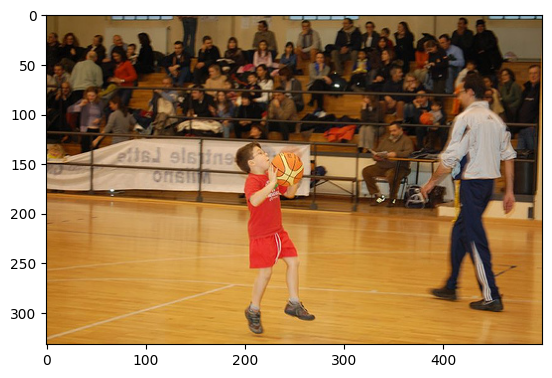

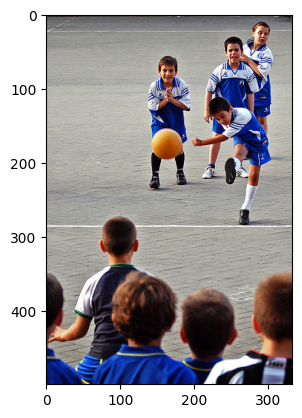

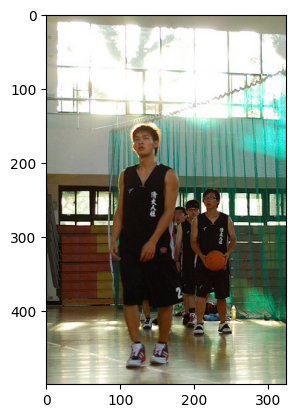

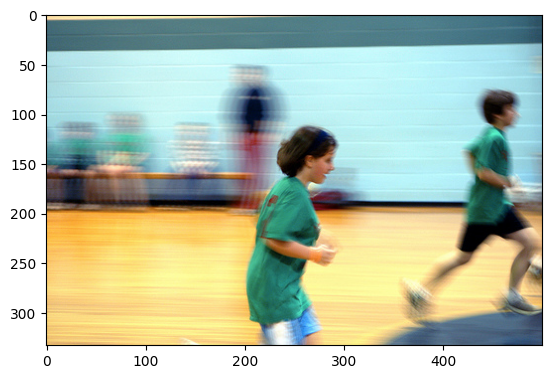

In [73]:
from PIL import Image
for idx, distance in indices_distances:
    path = image_path[idx]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()